# Term Deposit Marketing - PROJECT 2

## Background:

ACME is a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, at ACME we are looking to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

## Data Description:

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

## Attributes:

* age : age of customer (numeric)

* job : type of job (categorical)

* marital : marital status (categorical)

* education (categorical)

* default: has credit in default? (binary)

* balance: average yearly balance, in euros (numeric)

* housing: has a housing loan? (binary)

* loan: has personal loan? (binary)

* contact: contact communication type (categorical)

* day: last contact day of the month (numeric)

* month: last contact month of year (categorical)

* duration: last contact duration, in seconds (numeric)

* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

## Output (desired target):

* y - has the client subscribed to a term deposit? (binary)

## Download Data:

https://drive.google.com/file/d/1EW-XMnGfxn-qzGtGPa3v_C63Yqj2aGf7

## Goal(s):

Predict if the customer will subscribe (yes/no) to a term deposit (variable y)

## Success Metric(s):

Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.

## Bonus(es):

We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.

What makes the customers buy? Tell us which feature we should be focusing more on.



# Importing library and checking dataset

In [192]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import VotingClassifier
from tqdm import tqdm
from itertools import combinations, product
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.ensemble import VotingClassifier
from tqdm import tqdm
from itertools import combinations, product
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
# from sklearn.feature_selection import SequentialFeatureSelector

from pycaret.classification import * 

In [193]:
df = pd.read_csv('data.csv')

In [194]:
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no
39999,38,technician,married,secondary,no,1442,yes,no,cellular,3,jun,113,1,no


## Descriptive Data Analysis 


In [195]:
print("Data has ", df.shape[0], " number of rows and ", df.shape[1], " number of columns")

Data has  40000  number of rows and  14  number of columns


In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


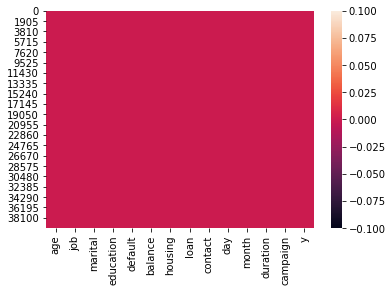

In [197]:
sns.heatmap(df.isna())
plt.show()

By looking at above image, there are no missing data in dataset.

In [198]:
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


We can find several information from it.

1. Age : Minimum age is 19 to apply. Maximum age is 95. Median and mean for this distribution is almost same about 40 years.


2. Balance: There are several customer with negative balances. It may be because nowdays banks offers overdraft protection. Which means there are several people who withdraw more money then they should. 


3. Day ranges from 1 to 31. This is actully categorical data.


4. Capaign is also categorical data.

In [199]:
neg_bal = float(len(df['balance'][df['balance']<0]))/float(len(df['balance']))
print("{:.2%}".format(neg_bal)+ " percent of people or "+str(int(neg_bal*11162))+ " people have a negative balance")

9.33% percent of people or 1041 people have a negative balance


In [200]:
df['job'].value_counts()

blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64

## Data Visulization

### Box plot of Descriptive data

In [201]:
numeric_features = ['age', 'balance', 'day', 'duration', 'campaign']
categorical_features = df.columns[df.dtypes == 'object']

print("numeric columns are  ", numeric_features)
print("categorical features are ", categorical_features)

numeric columns are   ['age', 'balance', 'day', 'duration', 'campaign']
categorical features are  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'y'],
      dtype='object')


<AxesSubplot:ylabel='y'>

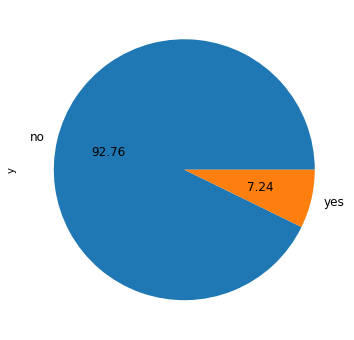

In [202]:
fig,axs = plt.subplots(figsize = (6,6))
df['y'].value_counts().plot(kind = 'pie', autopct='%.2f', fontsize = 12)

In [203]:
df_numeric = df[numeric_features]

In [204]:
df_numeric[df_numeric['campaign'] > 20]

,age,balance,day,duration,campaign
3079,28,0,14,17,24
3331,50,461,15,651,32
3475,42,497,15,84,22
3483,59,2319,15,132,32
3529,53,1140,15,241,32
...,...,...,...,...,...
23803,31,350,29,71,24
23965,30,1,29,69,21
30917,28,4987,9,253,21
31076,38,187,16,66,21


In [207]:
## remove high duration

df_numeric['duration'].quantile(0.975)

984.0

In [208]:
df[df['duration'] > 4000]#['y'].value_counts()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
24148,59,technician,married,tertiary,no,6573,yes,no,telephone,10,nov,4918,1,no


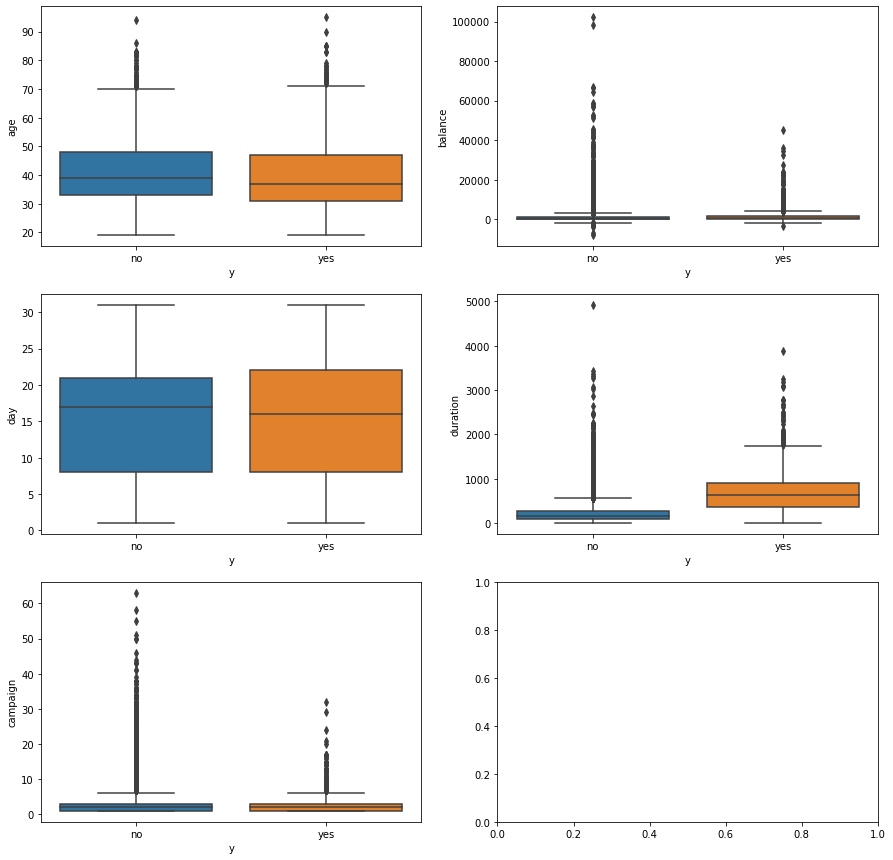

In [209]:
fig,axs = plt.subplots(3,2,figsize = (15,15))

for index, columns in enumerate(numeric_features):
    sns.boxplot(y = df[columns], ax = axs[index//2, index%2], x = df['y'])
    

Lets look Normalization plot.

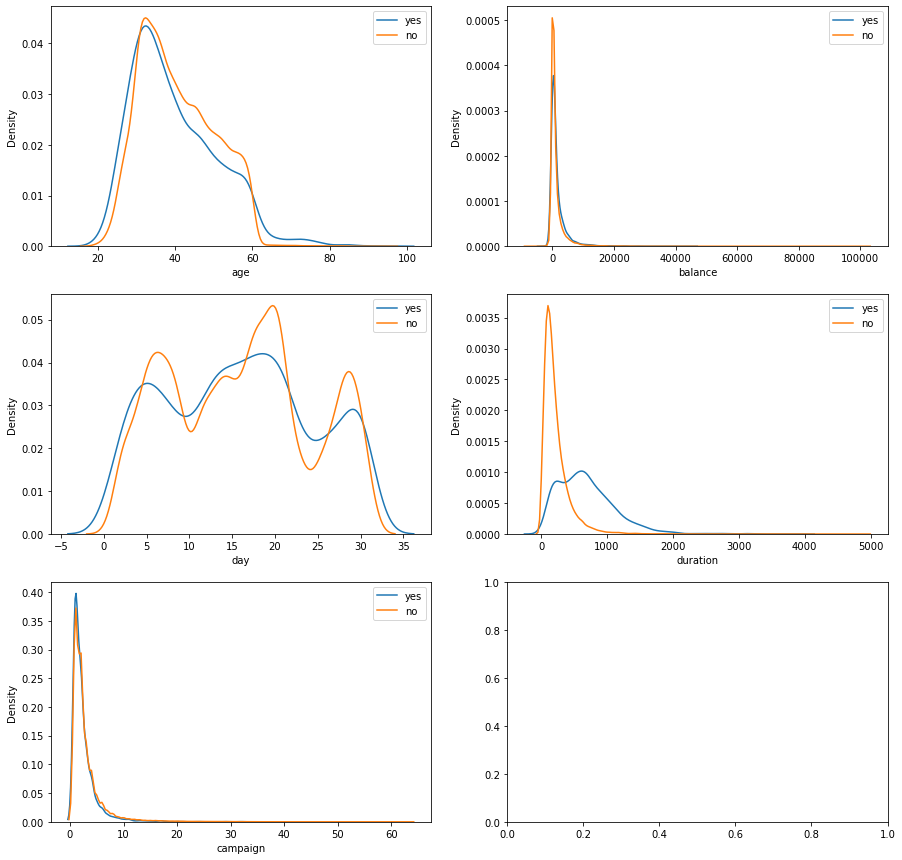

In [210]:
fig,axs = plt.subplots(3,2,figsize = (15,15))

for index, columns in enumerate(numeric_features):
    sns.kdeplot(df[df['y'] == 'yes'][columns], ax = axs[index//2, index%2], label = 'yes')
    sns.kdeplot(df[df['y'] == 'no'][columns], ax = axs[index//2, index%2], label = 'no')
    axs[index//2, index%2].legend()

In [211]:
df_numeric.skew()

age         0.436080
balance     8.259236
day         0.067930
duration    3.165307
campaign    4.730901
dtype: float64

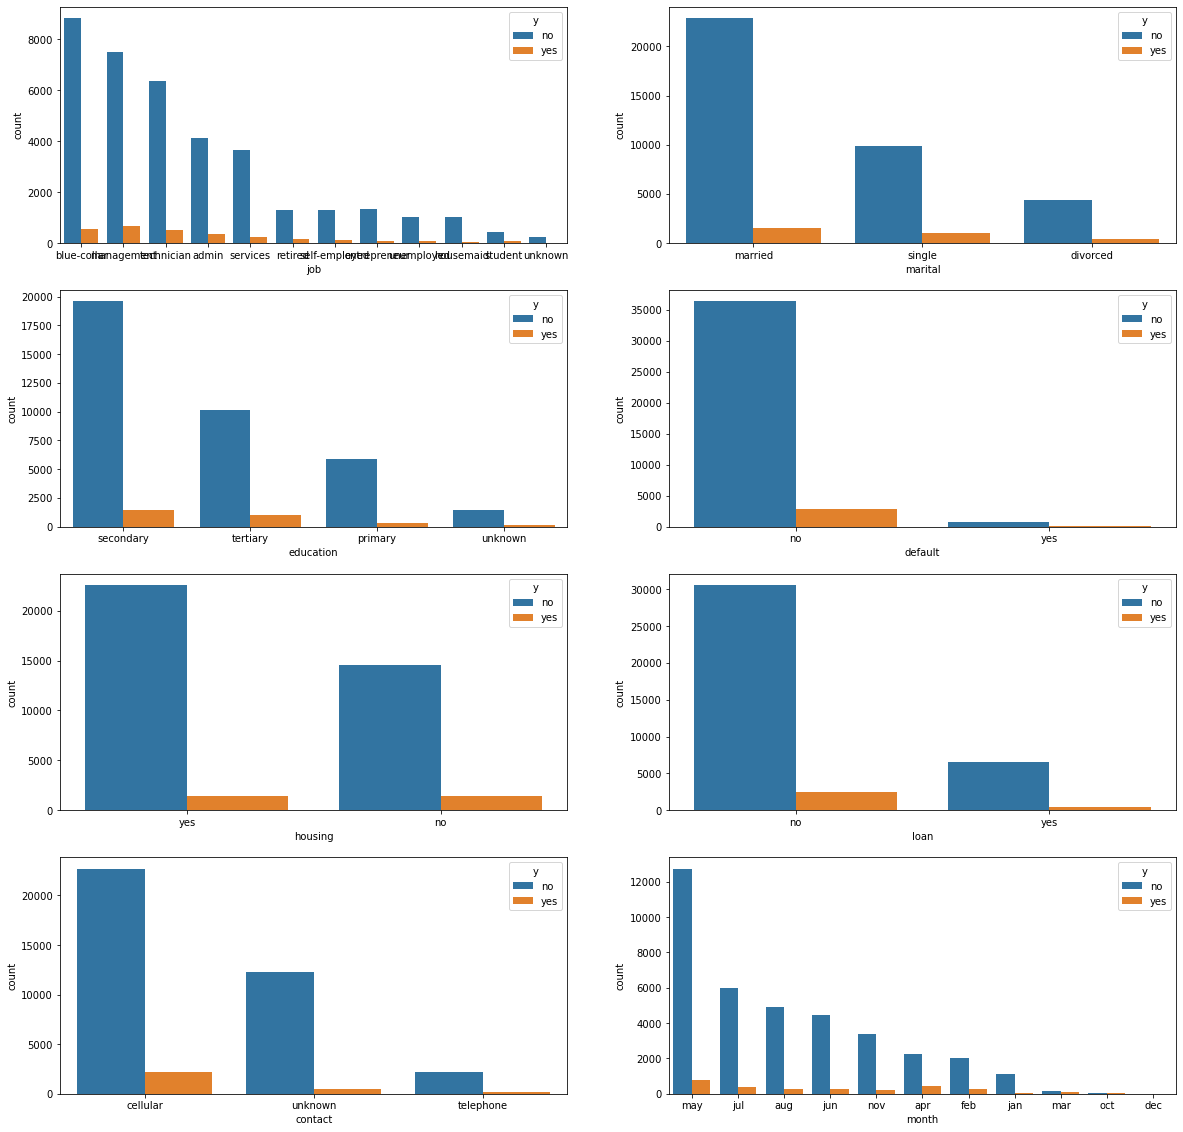

In [212]:
fig,axs = plt.subplots(4,2,figsize = (20,20))


for index, columns in enumerate(categorical_features[:-1]):

    sns.countplot(x = df[columns], ax = axs[index//2, index%2], order = df[columns].value_counts().index, hue = df['y'])

#     counts = df[str_columns[n]].value_counts()
#     plt.barh(y=counts.index, width=counts)
#     plt.title('Distribution of '+str_columns[n])
#     plt.ylabel(str_columns[n])
#     plt.xlabel('Count')

# plt.subplots_adjust(left=.25, bottom=2, right=2.75, top=4)

## Feature Engineering

In [213]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


## Convert Month to Quarters

In [214]:

df['month'] = df['month'].replace(to_replace = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug',
                                    'oct', 'nov', 'dec'], value = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12])
df['quarter'] = np.ceil(df['month']/3).astype('int')


## Create Age as Categorical

In [215]:
def _age_converter(x):
    if x < 30:
        return "19-30"
    elif x <40:
        return "30-40"
    elif x <50:
        return "40-50"
    elif x < 60:
        return "50-60"
    else:
        return "Above 60"

df['age_category'] = df['age'].apply(lambda x : _age_converter(x))

<AxesSubplot:xlabel='age_category', ylabel='count'>

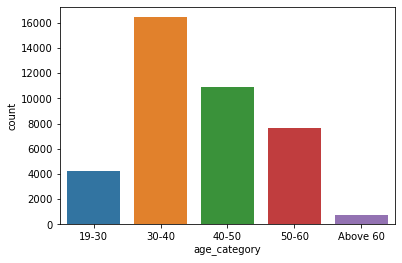

In [216]:
sns.countplot(df['age_category'], order=['19-30', "30-40", "40-50", "50-60", "Above 60",])

## Create Month day and Campaign as Category

In [217]:
df_featured = df.copy()

df_featured['day_category'] = df_featured['day'].apply(lambda x : 'early' if x < 8 else ('mid' if x < 22 else 'late'))
df_featured['campaign_category'] = df_featured['campaign'].apply(lambda x : 'lower' if x < 10 else
                                                                 ('middle' if x < 20 else 'higher'))



drop_columns = ['day', 'campaign', 'month', 'age']
df_featured = df_featured.drop(drop_columns, axis = 1)

In [218]:
df_featured.head()

,job,marital,education,default,balance,housing,loan,contact,duration,y,quarter,age_category,day_category,campaign_category
0,management,married,tertiary,no,2143,yes,no,unknown,261,no,2,50-60,early,lower
1,technician,single,secondary,no,29,yes,no,unknown,151,no,2,40-50,early,lower
2,entrepreneur,married,secondary,no,2,yes,yes,unknown,76,no,2,30-40,early,lower
3,blue-collar,married,unknown,no,1506,yes,no,unknown,92,no,2,40-50,early,lower
4,unknown,single,unknown,no,1,no,no,unknown,198,no,2,30-40,early,lower


In [219]:
df['duration'].describe()

count    40000.000000
mean       254.824300
std        259.366498
min          0.000000
25%        100.000000
50%        175.000000
75%        313.000000
max       4918.000000
Name: duration, dtype: float64

# Develop different buckets for call duration

In [220]:
def _duration_converter(x):
    if x < 50:
        return "0-50"
    elif x <100:
        return "50-100"
    elif x <175:
        return "100-175"
    elif x < 300:
        return "175-300"
    elif x <600:
        return "300-600"
    elif x < 1500:
        return "600-1500"
    else:
        return "Above 1500"

df['duration_category'] = df['duration'].apply(lambda x : _duration_converter(x))

<AxesSubplot:xlabel='duration_category', ylabel='count'>

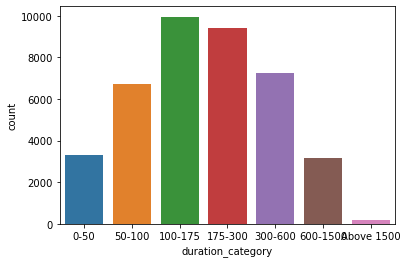

In [221]:
sns.countplot(df['duration_category'], order=['0-50', "50-100", "100-175", "175-300", "300-600","600-1500", "Above 1500" ])

## Combine Everything into one function

Later we will use similar concept to develop pipeline where raw data is fetched and feature engineering performed using pipeline

In [71]:
def _duration_converter(x):
    if x < 50:
        return "0-50"
    elif x <100:
        return "50-100"
    elif x <175:
        return "100-175"
    elif x < 300:
        return "175-300"
    elif x <600:
        return "300-600"
    elif x < 1500:
        return "600-1500"
    else:
        return "Above 1500"

def _age_converter(x):
    if x < 30:
        return "19-30"
    elif x <40:
        return "30-40"
    elif x <50:
        return "40-50"
    elif x < 60:
        return "50-60"
    else:
        return "Above 60"

def feature_engineer(X):
        X['day_category'] = X['day'].apply(lambda x : 'early' if x < 8 else ('mid' if x < 22 else 'late'))
        X['campaign_category'] = X['campaign'].apply(lambda x : 'lower' if x < 10 else
                                                                 ('middle' if x < 20 else 'higher'))
        
        X['month'] = X['month'].replace(to_replace = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug',
                                    'oct', 'nov', 'dec'], value = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12])
        X['quarter'] = np.ceil(X['month']/3).astype('int')       
        X['quarter'] = X['quarter'].astype('category')
        
        X['duration_category'] = X['duration'].apply(lambda x : _duration_converter(x))
        X['age_category'] = X['age'].apply(lambda x : _age_converter(x))
        
        
        drop_columns = ['day', 'campaign', 'month', 'duration', 'age']
        X = X.drop(drop_columns, axis = 1)    
        
        X['y'] = X['y'].apply(lambda x : 1 if x == 'yes' else 0)
        
        return X

## Create Sepearate Test set and keep it Aside

We will subset small set of data as test set and keep it seperatate. It will be evaluated to use prediction model. We will keep 20% of total data randomly sampled and put aside. 

We will work with rest 80% data for evaluation of model.

In [83]:


def genetate_train_test(df, test_size = 0.3):
    X = df.drop('y', axis=1)
    y = df['y']
    # Without stratifying, bootstrap
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    
#     X_train = pd.get_dummies(X_train, drop_first=False, columns= [ 'X1', 'X3', 'X5', 'X6'])
#     X_test = pd.get_dummies(X_test, drop_first= False, columns= [ 'X1', 'X3', 'X5', 'X6'])

    df_train = pd.concat([X_train, y_train], axis=1)
    df_test = pd.concat([X_test, y_test], axis=1)
    
    return df_train, df_test

In [129]:
df = pd.read_csv("data.csv")

df, df_test = genetate_train_test(df, test_size=0.2)

We have saved train data as "df". Hence forth we will use to develop model. df_test is dataset we have kept aside

## Develop Bootstrap dataset

We will performe several operation on our (train) dataset.

1) We will use function "feature engineering" to generate new features.

2) We will use function "undersampling" to under sample data

3) We will randomly generate 3 datasets with balanced ratio and evaluate classification models performance on each of them.

In [85]:
def get_undersampling(df, ratio =1):

    df_minor = df[df['y'] == 1]
    df_major = df[df['y'] == 0]
    
    df_major = df_major.sample(n = int(df_minor.shape[0] / ratio))
    df_undersample = pd.concat([df_major, df_minor]).sample(frac =1).reset_index(drop = True)
    return df_undersample

In [91]:


df1 = get_undersampling(feature_engineer(df.copy()), 1)
df2 = get_undersampling(feature_engineer(df.copy()), 1)
df3 = get_undersampling(feature_engineer(df.copy()), 1)

## Bootstrap Dataset1

Using pycaret we will evalaute which classification model performs better. 

In [92]:
exp_clf1001 = setup(data = df1, target = 'y', session_id=1001, train_size = 0.7,
                   normalize = True, remove_multicollinearity=True)

,Description,Value
0,session_id,1001
1,Target,y
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(4696, 14)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,12
8,Ordinal Features,False
9,High Cardinality Features,False


In [93]:
best_model = compare_models(fold=5, sort = 'F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8415,0.9120,0.8650,0.8256,0.8445,0.6830,0.6845,0.0380
rf,Random Forest Classifier,0.8379,0.9103,0.8454,0.8321,0.8385,0.6757,0.6761,0.1120
gbc,Gradient Boosting Classifier,0.8351,0.9112,0.8448,0.8277,0.8362,0.6702,0.6704,0.1080
et,Extra Trees Classifier,0.8254,0.8953,0.8271,0.8236,0.8251,0.6508,0.6512,0.1160
lr,Logistic Regression,0.8178,0.8957,0.8155,0.8184,0.8168,0.6355,0.6358,0.0260
ridge,Ridge Classifier,0.8111,0.0000,0.8015,0.8161,0.8086,0.6221,0.6223,0.0080
lda,Linear Discriminant Analysis,0.8111,0.8955,0.8009,0.8165,0.8085,0.6221,0.6224,0.0160
ada,Ada Boost Classifier,0.8071,0.8921,0.7954,0.8133,0.8041,0.6142,0.6145,0.0540
dt,Decision Tree Classifier,0.7880,0.7880,0.7874,0.7871,0.7872,0.5759,0.5760,0.0120
nb,Naive Bayes,0.7724,0.8494,0.8418,0.7381,0.7865,0.5451,0.5507,0.0100


In [94]:
gbc = create_model('gbc', fold=5)
tuned_gbc1 = tune_model(gbc, fold = 5, n_iter=100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8465,0.9142,0.8628,0.8348,0.8486,0.6930,0.6934
1,0.8404,0.9171,0.8780,0.8159,0.8458,0.6809,0.6829
2,0.8387,0.9137,0.8532,0.8279,0.8404,0.6774,0.6777
3,0.8432,0.9114,0.8532,0.8353,0.8442,0.6865,0.6866
4,0.8691,0.9270,0.9083,0.8414,0.8735,0.7383,0.7406
Mean,0.8476,0.9167,0.8711,0.8311,0.8505,0.6952,0.6962
SD,0.0111,0.0055,0.0207,0.0087,0.0118,0.0222,0.0228


In [95]:
rf = create_model('rf', fold=5)
tuned_rf1 = tune_model(rf, fold = 5, n_iter=100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8283,0.9043,0.8720,0.8011,0.8350,0.6566,0.6592
1,0.8389,0.9191,0.8933,0.8049,0.8468,0.6779,0.6820
2,0.8417,0.9164,0.8593,0.8289,0.8438,0.6835,0.6839
3,0.8417,0.9071,0.8654,0.8251,0.8448,0.6835,0.6843
4,0.8600,0.9191,0.9113,0.8255,0.8663,0.7201,0.7240
Mean,0.8421,0.9132,0.8803,0.8171,0.8474,0.6843,0.6867
SD,0.0102,0.0063,0.0193,0.0116,0.0103,0.0204,0.0209


In [96]:
et = create_model('et', fold=5)
tuned_et1 = tune_model(et, fold = 5, n_iter=100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8298,0.9041,0.8628,0.8086,0.8348,0.6596,0.6611
1,0.8404,0.9265,0.9024,0.8022,0.8494,0.6810,0.6863
2,0.8356,0.9143,0.8440,0.8288,0.8364,0.6713,0.6714
3,0.8417,0.9066,0.8532,0.8328,0.8429,0.6834,0.6836
4,0.8524,0.9202,0.9113,0.8142,0.8600,0.7049,0.7099
Mean,0.8400,0.9143,0.8748,0.8173,0.8447,0.6800,0.6825
SD,0.0075,0.0083,0.0270,0.0117,0.0092,0.0150,0.0164


## Bootstrap Dataset2

In [97]:
exp_clf2001 = setup(data = df2, target = 'y', session_id=2001, train_size = 0.7,
                   normalize = True, remove_multicollinearity=True)

,Description,Value
0,session_id,2001
1,Target,y
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(4696, 14)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,12
8,Ordinal Features,False
9,High Cardinality Features,False


In [98]:
best_model = compare_models(fold=5, sort = 'F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8549,0.9264,0.8686,0.8464,0.8570,0.7097,0.7106,0.1140
lightgbm,Light Gradient Boosting Machine,0.8427,0.9217,0.8649,0.8293,0.8466,0.6854,0.6863,0.0480
rf,Random Forest Classifier,0.8397,0.9166,0.8480,0.8355,0.8416,0.6793,0.6795,0.1120
lr,Logistic Regression,0.8321,0.9117,0.8231,0.8397,0.8311,0.6641,0.6647,0.0240
et,Extra Trees Classifier,0.8290,0.8952,0.8383,0.8244,0.8311,0.6580,0.6583,0.1240
ridge,Ridge Classifier,0.8260,0.0000,0.8068,0.8408,0.8230,0.6520,0.6531,0.0080
lda,Linear Discriminant Analysis,0.8260,0.9102,0.8068,0.8408,0.8230,0.6520,0.6531,0.0160
ada,Ada Boost Classifier,0.8239,0.9100,0.8056,0.8377,0.8212,0.6478,0.6484,0.0540
svm,SVM - Linear Kernel,0.8114,0.0000,0.7771,0.8383,0.8052,0.6229,0.6263,0.0160
nb,Naive Bayes,0.7989,0.8688,0.8274,0.7842,0.8051,0.5977,0.5987,0.0100


In [99]:
gbc = create_model('gbc', fold=5)
tuned_gbc2 = tune_model(gbc, fold = 5, n_iter=100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8511,0.9194,0.8822,0.8319,0.8563,0.7020,0.7033
1,0.8632,0.9265,0.8909,0.8448,0.8673,0.7264,0.7275
2,0.8676,0.9370,0.8970,0.8481,0.8719,0.7351,0.7363
3,0.8463,0.9215,0.8485,0.8459,0.8472,0.6925,0.6925
4,0.8539,0.9354,0.8636,0.8482,0.8559,0.7077,0.7079
Mean,0.8564,0.9280,0.8764,0.8438,0.8597,0.7127,0.7135
SD,0.0079,0.0071,0.0179,0.0061,0.0088,0.0157,0.0161


## Bootstrap Dataset3

In [101]:
exp_clf3001 = setup(data = df3, target = 'y', session_id=3001, train_size = 0.7,
                   normalize = True, remove_multicollinearity=True)




,Description,Value
0,session_id,3001
1,Target,y
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(4696, 14)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,12
8,Ordinal Features,False
9,High Cardinality Features,False


In [102]:
best_model = compare_models(fold=5, sort = 'F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8555,0.9220,0.8658,0.8448,0.8550,0.7110,0.7115,0.1180
lightgbm,Light Gradient Boosting Machine,0.8521,0.9224,0.8683,0.8377,0.8525,0.7044,0.7052,0.0360
rf,Random Forest Classifier,0.8506,0.9176,0.8547,0.8441,0.8492,0.7012,0.7016,0.1140
et,Extra Trees Classifier,0.8324,0.8999,0.8374,0.8252,0.8309,0.6647,0.6653,0.1200
lr,Logistic Regression,0.8327,0.9080,0.8268,0.8324,0.8295,0.6652,0.6654,0.0220
ada,Ada Boost Classifier,0.8309,0.9050,0.8163,0.8362,0.8260,0.6615,0.6619,0.0540
ridge,Ridge Classifier,0.8257,0.0000,0.8058,0.8344,0.8197,0.6511,0.6516,0.0100
lda,Linear Discriminant Analysis,0.8257,0.9063,0.8052,0.8349,0.8196,0.6511,0.6516,0.0160
dt,Decision Tree Classifier,0.8029,0.8029,0.8046,0.7971,0.8006,0.6057,0.6061,0.0120
svm,SVM - Linear Kernel,0.8105,0.0000,0.7655,0.8388,0.7982,0.6203,0.6255,0.0140


By looking at all 3 data, it looks like random forest, gradient boost classfier and light gbm model gives best result. Hoever, for our models we will use GBC, RF and ET for evaluation.


## Preprocessing Pipeline

Now that we finalize our top models, we will develop pre-processing pipeline. This pipeline will be used to transform raw data to feature engineered data. It will also perform several pre-processing such as removing multi-colineariry and generate one hot encoding

In [103]:
class Feature_Adder(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['day_category'] = X['day'].apply(lambda x : 'early' if x < 8 else ('mid' if x < 22 else 'late'))
        X['campaign_category'] = X['campaign'].apply(lambda x : 'lower' if x < 10 else
                                                                 ('middle' if x < 20 else 'higher'))
        
        X['month'] = X['month'].replace(to_replace = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug',
                                    'oct', 'nov', 'dec'], value = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12])
        
        X['quarter'] = np.ceil(X['month']/3).astype('int')        
        X['quarter'] = X['quarter'].astype('category')
        
        X['duration_category'] = X['duration'].apply(lambda x : _duration_converter(x))
        X['age_category'] = X['age'].apply(lambda x : _age_converter(x))
        
        
        
        drop_columns = ['day', 'campaign', 'month', 'duration', 'age']
        X = X.drop(drop_columns, axis = 1)        
       
        print("Feature Adder commpleted............")
        return X
    
    def _duration_converter(x):
        if x < 50:
            return "0-50"
        elif x <100:
            return "50-100"
        elif x <175:
            return "100-175"
        elif x < 300:
            return "175-300"
        elif x <600:
            return "300-600"
        elif x < 1500:
            return "600-1500"
        else:
            return "Above 1500"

    def _age_converter(x):
        if x < 30:
            return "19-30"
        elif x <40:
            return "30-40"
        elif x <50:
            return "40-50"
        elif x < 60:
            return "50-60"
        else:
            return "Above 60"
    
    

In [104]:
class DimReduction(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''

    def __init__(self):
        self.columns_to_drop = []
        pass

    def fit(self, X, y=None):
        # Find feature where the missing values are more than 60%
#         missing_columns = X.columns[X.isna().mean() > 0.6].to_list()
        # Find feature where variance is very low
        columns_with_small_variance = list(X.std()[(X.std() < 0.01)].index)
        # Remove Highly correlated features
        corr_matrix = X.corr().abs()
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        tri_df = corr_matrix.mask(mask)
        high_correlated_columns = [c for c in tri_df.columns
                                   if any(tri_df[c] >  0.9)]
        
        self.columns_to_drop = list(set(#missing_columns +
                                        columns_with_small_variance +
                                        high_correlated_columns)) 
        
        return self

    def transform(self, X):
        # transform X via code or additional methods
        X = X.drop(self.columns_to_drop, axis=1)
        
        print("Dimensionality reduced............")
        return X

In [105]:
class Binary_Labelizer(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
       
        X = pd.get_dummies(X, drop_first=True)

        
        print("One Hot Encoding Performed............")
        return X

In [106]:
data_pipeline = Pipeline([('feature_adder', Feature_Adder()),
                          ('dimensionality_reduction', DimReduction()),
                          ('ohe', Binary_Labelizer()),
                         ])

In [130]:
df['y'] = df['y'].apply(lambda x : 1 if x == 'yes' else 0)
df_balanced = get_undersampling(df, 1)

In [131]:
X = df_balanced.drop('y', axis=1)
y = df_balanced['y']



X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, random_state = 42)

In [132]:
X_train_preprocessed = data_pipeline.fit_transform(X_train)
X_test_preprocessed = data_pipeline.transform(X_test)

Feature Adder commpleted............
Dimensionality reduced............
One Hot Encoding Performed............
Feature Adder commpleted............
Dimensionality reduced............
One Hot Encoding Performed............


In [133]:
X_train_preprocessed.head()

,balance,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,duration_category_100-175,duration_category_175-300,duration_category_300-600,duration_category_50-100,duration_category_600-1500,duration_category_Above 1500,age_category_30-40,age_category_40-50,age_category_50-60,age_category_Above 60
2019,428,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3052,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3519,10,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2211,115,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3361,2112,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


## Ensemble Models

In [134]:
models = [tuned_gbc2, tuned_et1, tuned_rf1]
model_names = ['tuned_gbc1', 'tuned_et1', 'tuned_rf1']

In [136]:


def weighted_voting(estimators, estimator_names, X_train, y_train, X_test, y_test):

    weights = np.round([np.arange(0.1,1,0.1)]*(len(estimators)),1)
    df_weights = pd.DataFrame(columns=['n_models', 'models', 'weights',
                                       'train_accuracy', 'test_accuracy',
                                       'train_f1score', 'test_f1score',
                                       'train_precision', 'test_precision',
                                       'train_recall', 'test_recall',])
    for weight in tqdm(product(*weights)):
        weight_sum = np.round(np.sum(weight),1)
        if weight_sum == 1:
            clf_voting = VotingClassifier(estimators = list(zip(estimator_names, estimators)),
                                          voting = 'soft', weights= list(weight))
    
            train_accuracy = cross_val_score(clf_voting, X_train, y_train, scoring='accuracy', cv=5)
            train_f1score = cross_val_score(clf_voting, X_train, y_train, scoring='f1', cv=5)
            train_precision = cross_val_score(clf_voting, X_train, y_train, scoring='precision', cv=5)
            train_recall = cross_val_score(clf_voting, X_train, y_train, scoring='recall', cv=5)
        
            clf_voting.fit(X_train, y_train)
#             y_pred_train =  clf_voting.predict(X_train)
            y_pred = clf_voting.predict(X_test)
#             print(score)
#             train_score = accuracy_score(y_train, y_pred_train)
            test_accuracy = accuracy_score(y_test, y_pred)
            test_f1score = f1_score(y_test, y_pred)    
            test_precision = precision_score(y_test, y_pred)    
            test_recall = recall_score(y_test, y_pred)    
    
            df_weights.loc[len(df_weights)] = [len(estimators),
                                               estimator_names,
                                               list(weight),
                                               np.round(np.mean(train_accuracy),4), np.round(np.mean(test_accuracy),4),
                                               np.round(np.mean(train_f1score),4), np.round(np.mean(test_f1score),4),
                                               np.round(np.mean(train_precision),4), np.round(np.mean(test_precision),4),
                                               np.round(np.mean(train_recall),4), np.round(np.mean(test_recall),4)
                                              ]
    return df_weights

In [137]:
score_df = weighted_voting(models, model_names, X_train_preprocessed, y_train, X_test_preprocessed, y_test)

729it [06:11,  1.96it/s]


In [138]:
score_df.head()

,n_models,models,weights,train_accuracy,test_accuracy,train_f1score,test_f1score,train_precision,test_precision,train_recall,test_recall
0,3,"[tuned_gbc1, tuned_et1, tuned_rf1]","[0.1, 0.1, 0.8]",0.8374,0.8441,0.8393,0.8532,0.8157,0.8378,0.8645,0.8693
1,3,"[tuned_gbc1, tuned_et1, tuned_rf1]","[0.1, 0.2, 0.7]",0.8387,0.8419,0.8405,0.8511,0.8169,0.8362,0.8657,0.8665
2,3,"[tuned_gbc1, tuned_et1, tuned_rf1]","[0.1, 0.3, 0.6]",0.8393,0.8412,0.8410,0.8505,0.8179,0.8351,0.8657,0.8665
3,3,"[tuned_gbc1, tuned_et1, tuned_rf1]","[0.1, 0.4, 0.5]",0.8415,0.8412,0.8433,0.8503,0.8193,0.8360,0.8689,0.8651
4,3,"[tuned_gbc1, tuned_et1, tuned_rf1]","[0.1, 0.5, 0.4]",0.8412,0.8397,0.8429,0.8489,0.8196,0.8347,0.8676,0.8637


In [139]:
score_df.sort_values(by = 'test_accuracy', ascending = False).head(5)

,n_models,models,weights,train_accuracy,test_accuracy,train_f1score,test_f1score,train_precision,test_precision,train_recall,test_recall
30,3,"[tuned_gbc1, tuned_et1, tuned_rf1]","[0.6, 0.1, 0.3]",0.8418,0.8550,0.8421,0.8621,0.8257,0.8550,0.8594,0.8693
33,3,"[tuned_gbc1, tuned_et1, tuned_rf1]","[0.7, 0.1, 0.2]",0.8421,0.8542,0.8422,0.8609,0.8269,0.8567,0.8581,0.8651
34,3,"[tuned_gbc1, tuned_et1, tuned_rf1]","[0.7, 0.2, 0.1]",0.8427,0.8528,0.8429,0.8597,0.8272,0.8544,0.8594,0.8651
31,3,"[tuned_gbc1, tuned_et1, tuned_rf1]","[0.6, 0.2, 0.2]",0.8427,0.8528,0.8431,0.8599,0.8264,0.8534,0.8607,0.8665
26,3,"[tuned_gbc1, tuned_et1, tuned_rf1]","[0.5, 0.1, 0.4]",0.8415,0.8521,0.8425,0.8591,0.8228,0.8532,0.8632,0.8651


In [141]:
score_df.sort_values(by= 'test_f1score', ascending = False).head(5)

,n_models,models,weights,train_accuracy,test_accuracy,train_f1score,test_f1score,train_precision,test_precision,train_recall,test_recall
30,3,"[tuned_gbc1, tuned_et1, tuned_rf1]","[0.6, 0.1, 0.3]",0.8418,0.8550,0.8421,0.8621,0.8257,0.8550,0.8594,0.8693
33,3,"[tuned_gbc1, tuned_et1, tuned_rf1]","[0.7, 0.1, 0.2]",0.8421,0.8542,0.8422,0.8609,0.8269,0.8567,0.8581,0.8651
31,3,"[tuned_gbc1, tuned_et1, tuned_rf1]","[0.6, 0.2, 0.2]",0.8427,0.8528,0.8431,0.8599,0.8264,0.8534,0.8607,0.8665
34,3,"[tuned_gbc1, tuned_et1, tuned_rf1]","[0.7, 0.2, 0.1]",0.8427,0.8528,0.8429,0.8597,0.8272,0.8544,0.8594,0.8651
32,3,"[tuned_gbc1, tuned_et1, tuned_rf1]","[0.6, 0.3, 0.1]",0.8402,0.8521,0.8407,0.8595,0.8236,0.8513,0.8588,0.8679


## Check untouched test data

In [142]:
df_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
15673,56,housemaid,married,secondary,no,619,yes,no,telephone,21,jul,65,1,no
35141,36,blue-collar,married,secondary,no,975,yes,no,cellular,7,may,186,2,no
1345,42,admin,married,secondary,no,323,yes,yes,unknown,8,may,280,2,no
2560,28,blue-collar,married,secondary,no,64,yes,no,unknown,13,may,160,3,no
15633,41,technician,married,secondary,no,525,yes,no,cellular,21,jul,108,1,no


In [149]:
df_test['y'] = df_test['y'].apply(lambda x : 1 if x == 'yes' else 0)
df_test['y'].value_counts(normalize = True)


0    0.92525
1    0.07475
Name: y, dtype: float64

In [150]:
test_X = df_test.drop('y', axis=1)
test_y = df_test['y']

test_X_preprocessed = data_pipeline.transform(test_X)

test_X_preprocessed.head()

Feature Adder commpleted............
Dimensionality reduced............
One Hot Encoding Performed............


,balance,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,duration_category_100-175,duration_category_175-300,duration_category_300-600,duration_category_50-100,duration_category_600-1500,duration_category_Above 1500,age_category_30-40,age_category_40-50,age_category_50-60,age_category_Above 60
15673,619,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
35141,975,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1345,323,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2560,64,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
15633,525,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


In [151]:
models = [tuned_gbc2, tuned_et1, tuned_rf1]
model_names = ['tuned_gbc1', 'tuned_et1', 'tuned_rf1']
weights = [0.6, 0.1, 0.3]

clf = VotingClassifier(list(zip(model_names, models)), voting = 'soft', weights= weights)

clf.fit(X_train_preprocessed, y_train)

pred_y = clf.predict(test_X_preprocessed)
#             print(score)
#             train_score = accuracy_score(y_train, y_pred_train)


test_accuracy = accuracy_score(test_y, pred_y)
test_f1score = f1_score(test_y, pred_y)    
test_precision = precision_score(test_y, pred_y)    
test_recall = recall_score(test_y, pred_y)   

print("test data accuracy : ", np.round(test_accuracy, 4), "\n",
      "test data f1score : ", np.round(test_f1score, 4), "\n",
      "test data precision : ", np.round(test_precision, 4), "\n",
      "test data recall : ", np.round(test_recall, 4), "\n",
     )

test data accuracy :  0.8339 
 test data f1score :  0.4376 
 test data precision :  0.2929 
 test data recall :  0.8645 



## Sequential backward Feature Selection

In [173]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X = X.values
        #split training data into train and validation subsets
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []
            # look at all combinations of dim-1 features 
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        ## TODO  please complete!
        # using crossfold validation select the single best model from among all selected subsets
        # using cross-validated performance utility
        
        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

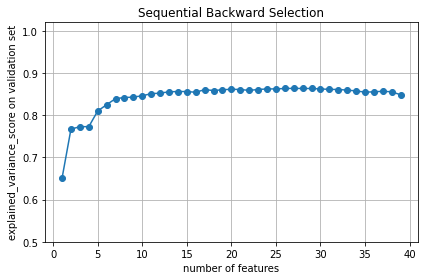

In [174]:
models = [tuned_gbc2, tuned_et1, tuned_rf1]
model_names = ['tuned_gbc1', 'tuned_et1', 'tuned_rf1']
weights = [0.6, 0.1, 0.3]

clf = VotingClassifier(list(zip(model_names, models)), voting = 'soft', weights= weights)



# selecting features
sbs = SBS(clf, k_features=1, scoring=f1_score)
sbs.fit(X_train_preprocessed, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

#plot places the points on the graph using the number of features (no need to sort!)
plt.plot(k_feat, sbs.scores_, marker='o')  
plt.ylim([0.5, 1.02])
plt.title("Sequential Backward Selection")
plt.ylabel('explained_variance_score on validation set')
plt.xlabel(r'number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [178]:
feature_df = pd.DataFrame(list(zip( k_feat, np.round(sbs.scores_, 3), sbs.subsets_)  ),
                         columns = ['n_features', 'F1-score', 'Features'])

In [182]:
best_nfeature = feature_df[feature_df['F1-score'] == feature_df['F1-score'].max()]

In [183]:
best_nfeature

,n_features,F1-score,Features
12,27,0.864,"(2, 3, 4, 5, 6, 7, 11, 13, 15, 17, 18, 20, 21,..."


In [223]:
 min_features = [X_train_preprocessed.columns[i] for i in best_nfeature['Features'].values[0]]

In [224]:
min_features

['job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_unknown',
 'marital_single',
 'education_tertiary',
 'default_yes',
 'housing_yes',
 'contact_telephone',
 'contact_unknown',
 'day_category_late',
 'day_category_mid',
 'quarter_2',
 'quarter_3',
 'quarter_4',
 'duration_category_100-175',
 'duration_category_175-300',
 'duration_category_300-600',
 'duration_category_50-100',
 'duration_category_600-1500',
 'duration_category_Above 1500',
 'age_category_40-50',
 'age_category_50-60',
 'age_category_Above 60']

# Check Test Data with minimum features

In [227]:
display(X_train_preprocessed.head())

display(test_X_preprocessed.head())

,balance,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,duration_category_100-175,duration_category_175-300,duration_category_300-600,duration_category_50-100,duration_category_600-1500,duration_category_Above 1500,age_category_30-40,age_category_40-50,age_category_50-60,age_category_Above 60
2019,428,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3052,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3519,10,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2211,115,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3361,2112,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


,balance,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,duration_category_100-175,duration_category_175-300,duration_category_300-600,duration_category_50-100,duration_category_600-1500,duration_category_Above 1500,age_category_30-40,age_category_40-50,age_category_50-60,age_category_Above 60
15673,619,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
35141,975,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1345,323,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2560,64,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
15633,525,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


In [228]:
X_train_preprocessed_min_features = X_train_preprocessed[min_features]

test_X_preprocessed_min_features = test_X_preprocessed[min_features]

In [229]:
models = [tuned_gbc2, tuned_et1, tuned_rf1]
model_names = ['tuned_gbc1', 'tuned_et1', 'tuned_rf1']
weights = [0.6, 0.1, 0.3]

clf = VotingClassifier(list(zip(model_names, models)), voting = 'soft', weights= weights)

clf.fit(X_train_preprocessed_min_features, y_train)

pred_y = clf.predict(test_X_preprocessed_min_features)
#             print(score)
#             train_score = accuracy_score(y_train, y_pred_train)


test_accuracy = accuracy_score(test_y, pred_y)
test_f1score = f1_score(test_y, pred_y)    
test_precision = precision_score(test_y, pred_y)    
test_recall = recall_score(test_y, pred_y)   

print("test data accuracy : ", np.round(test_accuracy, 4), "\n",
      "test data f1score : ", np.round(test_f1score, 4), "\n",
      "test data precision : ", np.round(test_precision, 4), "\n",
      "test data recall : ", np.round(test_recall, 4), "\n",
     )

test data accuracy :  0.8322 
 test data f1score :  0.4347 
 test data precision :  0.2905 
 test data recall :  0.8629 



In [252]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_y, pred_y)

array([[6142, 1260],
       [  82,  516]], dtype=int64)

# Conclusion

We can see that there several features such as balance is not important for predicting customer output. Also, there is more likely people with age greater than 40 more like to contribute to our model. Also if call duration less than 50 seconds does not contribute to prediction.

Also we can see higher education have storong impact on our prediction.

However, we can see that model performs poor interms of F1-score for test data.

## Extra Effort

Check for various thresholds

In [230]:
models = [tuned_gbc2, tuned_et1, tuned_rf1]
model_names = ['tuned_gbc1', 'tuned_et1', 'tuned_rf1']
weights = [0.6, 0.1, 0.3]

clf = VotingClassifier(list(zip(model_names, models)), voting = 'soft', weights= weights)

clf.fit(X_train_preprocessed_min_features, y_train)

pred_y_proba = clf.predict_proba(test_X_preprocessed_min_features)
#             print(score)
#             train_score = accuracy_score(y_train, y_pred_train)


# test_accuracy = accuracy_score(test_y, pred_y)
# test_f1score = f1_score(test_y, pred_y)    
# test_precision = precision_score(test_y, pred_y)    
# test_recall = recall_score(test_y, pred_y)   

# print("test data accuracy : ", np.round(test_accuracy, 4), "\n",
#       "test data f1score : ", np.round(test_f1score, 4), "\n",
#       "test data precision : ", np.round(test_precision, 4), "\n",
#       "test data recall : ", np.round(test_recall, 4), "\n",
#      )

In [235]:
threshold = np.arange(0.1,1,0.05)
threshold

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [236]:
threshold_df = pd.DataFrame(columns = ['Threshold', 'accuracy', 'f1-score', 'precision', 'recall'])

for t in threshold:
    pred_y_threshold = np.where(pred_y_proba[:,1] > t, 1, 0)
    
    test_accuracy = accuracy_score(test_y, pred_y_threshold)    
    test_f1score = f1_score(test_y, pred_y_threshold)    
    test_precision = precision_score(test_y, pred_y_threshold)    
    test_recall = recall_score(test_y, pred_y_threshold)   
    
    threshold_df.loc[len(threshold_df)] = [t, np.round(test_accuracy, 4), np.round(test_f1score, 4),
                                          np.round(test_precision, 4), np.round(test_recall, 4)]

# print("test data accuracy : ", np.round(test_accuracy, 4), "\n",
#       "test data f1score : ", np.round(test_f1score, 4), "\n",
#       "test data precision : ", np.round(test_precision, 4), "\n",
#       "test data recall : ", np.round(test_recall, 4), "\n",
#      )
threshold_df   

,Threshold,accuracy,f1-score,precision,recall
0,0.10,0.5339,0.2407,0.1370,0.9883
1,0.15,0.5981,0.2682,0.1552,0.9849
2,0.20,0.6637,0.3035,0.1795,0.9799
3,0.25,0.7052,0.3297,0.1986,0.9699
4,0.30,0.7346,0.3506,0.2145,0.9582
5,0.35,0.7649,0.3711,0.2319,0.9281
6,0.40,0.7906,0.3942,0.2515,0.9114
7,0.45,0.8091,0.4116,0.2674,0.8930
8,0.50,0.8322,0.4347,0.2905,0.8629
9,0.55,0.8476,0.4472,0.3068,0.8244


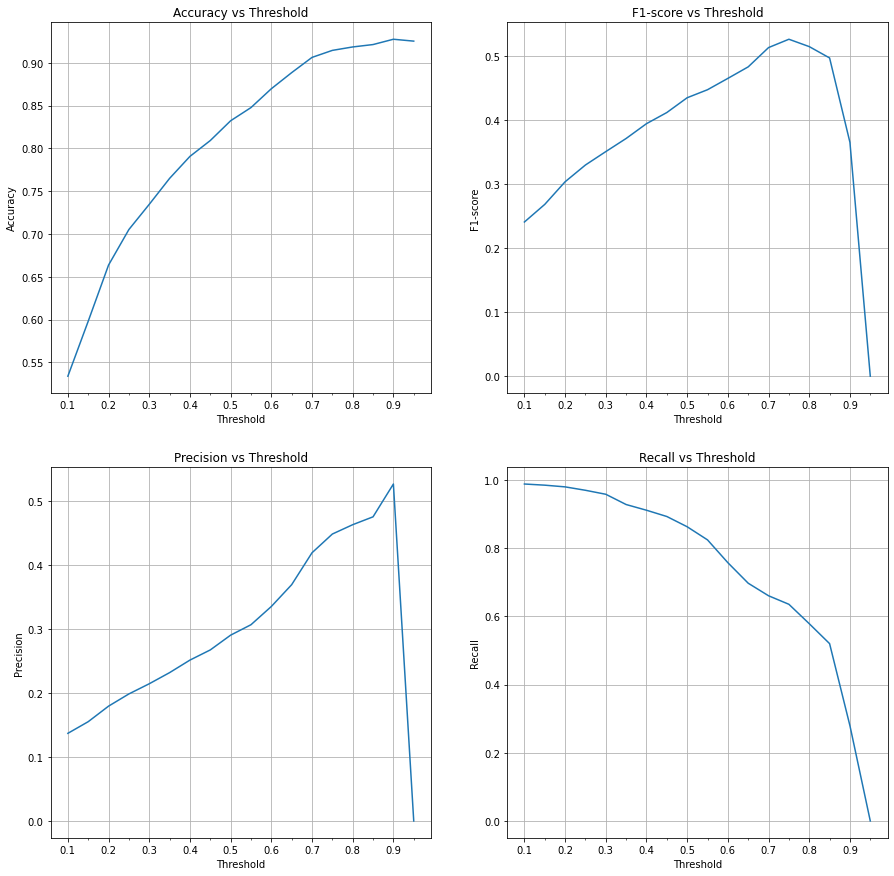

In [251]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


fig,axs = plt.subplots(2,2,figsize=(15,15))

axs[0,0].plot(threshold_df['Threshold'], threshold_df['accuracy'])
axs[0][0].set_title("Accuracy vs Threshold")
axs[0][0].set_xlabel("Threshold")
axs[0][0].set_ylabel("Accuracy")
axs[0][0].grid()
axs[0][0].xaxis.set_major_locator(MultipleLocator(0.1))
axs[0][0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
# For the minor ticks, use no labels; default NullFormatter.
axs[0][0].xaxis.set_minor_locator(MultipleLocator(0.05))



axs[0,1].plot(threshold_df['Threshold'], threshold_df['f1-score'])
axs[0,1].set_title("F1-score vs Threshold")
axs[0,1].set_xlabel("Threshold")
axs[0,1].set_ylabel("F1-score")
axs[0,1].grid()
axs[0,1].xaxis.set_major_locator(MultipleLocator(0.1))
axs[0,1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
# For the minor ticks, use no labels; default NullFormatter.
axs[0,1].xaxis.set_minor_locator(MultipleLocator(0.05))


axs[1,0].plot(threshold_df['Threshold'], threshold_df['precision'])
axs[1,0].set_title("Precision vs Threshold")
axs[1,0].set_xlabel("Threshold")
axs[1,0].set_ylabel("Precision")
axs[1,0].grid()
axs[1,0].xaxis.set_major_locator(MultipleLocator(0.1))
axs[1,0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
# For the minor ticks, use no labels; default NullFormatter.
axs[1,0].xaxis.set_minor_locator(MultipleLocator(0.05))



axs[1,1].plot(threshold_df['Threshold'], threshold_df['recall'])
axs[1,1].set_title("Recall vs Threshold")
axs[1,1].set_xlabel("Threshold")
axs[1,1].set_ylabel("Recall")
axs[1,1].grid()
axs[1,1].xaxis.set_major_locator(MultipleLocator(0.1))
axs[1,1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
# For the minor ticks, use no labels; default NullFormatter.
axs[1,1].xaxis.set_minor_locator(MultipleLocator(0.05))
